# STATS 542: Homework 10

<h4><center> Diego Kleiman (diegoek2) </center></h4>
<h4><center> Due: Tuesday 11:59 PM CT, Apr 13th </center></h4>

## About HW10

This homework involves two coding questions. One is discriminant analysis, and another one is logistic regression. 

## Question 1 [50 Points] Discriminant Analysis

For this question, you need to write your own code. We will use the handwritten digit recognition data again from the `ElemStatLearn` package. Pool the `zip.train` and `zip.test` data together. Randomly select 1000 observations as the training data and the rest as testing data. No cross-validation is needed. Make sure to save seed. 

### a) [25 points] Linear discriminate analysis

Write your own linear discriminate analysis (LDA) code following our lecture note. Use the training data to estimate all parameters and apply them to the testing data to evaluate the performance. You may face computational problems when calculating the log-determinate. Figure out ways to solve that. Report the model fitting results (such as a confusion table and misclassification rates). Which digit seems to get misclassified the most? 

In [1]:
# Load data
import os
os.environ['R_HOME'] = "/Users/diegoeduardo/opt/anaconda3/envs/R/lib/R"
import rpy2.robjects as robjects
import numpy as np

# Load datasets
robjects.r['load']('zip.train.RData')
robjects.r['load']('zip.test.RData')

# Retrieve datsets as Python objects
zip_train = robjects.r['zip.train']
zip_test = robjects.r['zip.test']

# Convert to numpy.ndarray
zip_train = np.array(zip_train)
zip_test = np.array(zip_test)

In [2]:
# Extra libraries I can use to report results
from sklearn.metrics import confusion_matrix

In [3]:
# Change train/test split according to question requirements
X_train = zip_train[:, 1:]
X_test = zip_test[:, 1:]

y_train = zip_train[:, 0]
y_test = zip_test[:, 0]

temp_X = np.vstack((X_train, X_test))
temp_y = np.concatenate((y_train, y_test))

np.random.seed(1) # Random seed
shuffled_indices = np.random.choice(temp_X.shape[0], replace=False, size=temp_X.shape[0])
train_indices = shuffled_indices[:1000]
test_indices = shuffled_indices[1000:]

X_train, y_train = temp_X[train_indices], temp_y[train_indices].astype(int)
X_test, y_test = temp_X[test_indices], temp_y[test_indices].astype(int)

In [4]:
def linear_discriminant(X, y):
    '''
    Fits linear discriminant analysis parameters from training data X and training outcomes y.
    
    Arguments
    --------------
    X: np.ndarray of shape (n_samples, n_features). Training data.
    y: np.ndarray of shape (n_samples,). Training outcomes. Labels must be in range [0, n_classes).
    
    Returns
    --------------
    dict with keys:
        'predictions': np.ndarray of shape (n_samples,). Predicted outcomes for training data.
        'error': float. Classification error for training data.
        'conf_matrix': np.ndarray of shape (n_classes, n_classes). Confusion matrix (normalized) for training data.
        'misclass_rates': np.ndarray of shape (n_classes,). Misclassification rate for each class.
        'model': callable. Function that returns predicted labels for new data.
        'params': tuple of (w, b). Fitted parameters for LDA.
            w: np.ndarray of shape (n_classes, n_features). 
            b: np.ndarray of shape (n_classes.)
    '''
    
    n_samples, n_features = X.shape
    classes, counts = np.unique(y, return_counts=True)
    n_classes = classes.shape[0]
    
    priors = compute_priors(counts)
    centroids = compute_centroids(X, y, classes, n_classes, n_features)
    # We are assuming the covariance matrix is the same for every class
    covariance = compute_covariance(X, y, centroids, classes, n_samples, n_features, n_classes)
    params = compute_params(priors, covariance, centroids, classes, n_features, n_classes)
    model = lda_model(params)
    predictions = model(X)
    error = classification_error(y, predictions)
    conf_matrix = confusion_matrix(y, predictions, normalize='true')
    misclass_rates = 1 - conf_matrix.diagonal()
    
    output = {}
    output['predictions'] = predictions
    output['error'] = error
    output['conf_matrix'] = conf_matrix
    output['misclass_rates'] = misclass_rates
    output['model'] = model
    output['params'] = params
    
    return output
    
def compute_priors(counts):
    '''
    Helper function to compute prior probabilities.
    '''
    total = counts.sum() 
    return counts/total

def compute_centroids(X, y, classes, n_classes, n_features):
    '''
    Helper function to compute centroids.
    '''
    centroids = np.empty((n_classes, n_features))
    
    for k in classes:
        mask = np.where(y == k)
        Xk = X[mask]
        centroids[k] = Xk.mean(axis=0)
        
    return centroids

def compute_covariance(X, y, centroids, classes, n_samples, n_features, n_classes):
    '''
    Helper function to compute covariance matrix.
    '''
    covariance = np.zeros((n_features, n_features))
    
    for k in classes:
        mask = np.where(y == k)
        centroid = centroids[k]
        Xk = X[mask]
        covariance += np.cov(Xk, rowvar=False, bias=n_classes)

    return covariance

def compute_params(priors, covariance, centroids, classes, n_features, n_classes):
    '''
    Helper function to compute LDA parameters (w_k's and b_k's).
    '''
    w = np.empty((n_classes, n_features))
    b = np.empty(n_classes)
    
    cov_inv = np.linalg.inv(covariance)
    
    for k in classes:
        centroid = centroids[k]
        prior = priors[k]
        b[k] = -0.5*np.matmul(centroid, np.matmul(cov_inv, centroid.T)) + np.log(prior)
        w[k] = np.matmul(cov_inv, centroid)
    
    return w, b

def lda_model(params):
    '''
    Returns a callable LDA model.
    '''
    
    w, b = params
    
    def model(X):
        A = np.matmul(X, w.T)
        R = A + b
        pred = np.argmax(R, axis=1)
        
        return pred
    
    return model

def classification_error(y, predictions):
    '''
    Computes classification error for true lables y and predictions pred.
    '''
    
    assert(y.shape == predictions.shape)
    n_samples = y.shape[0]
    
    return np.count_nonzero(np.where(y != predictions))/n_samples

In [5]:
results = linear_discriminant(X_train, y_train)

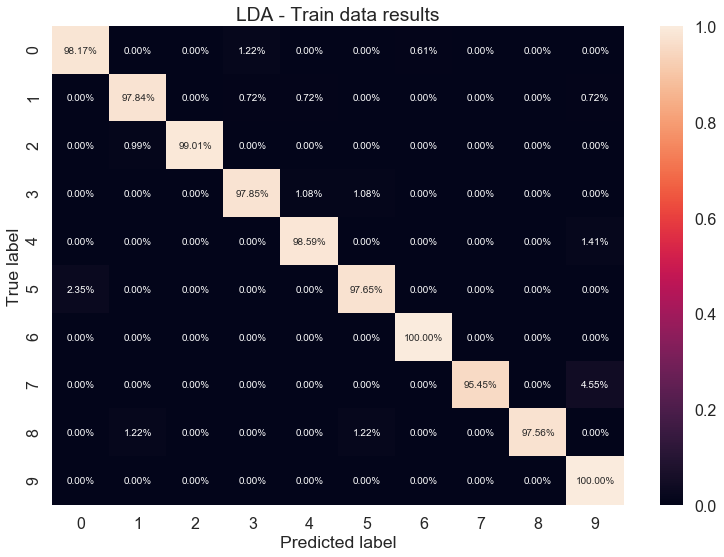

In [6]:
import seaborn as sbn
from matplotlib import pyplot as plt
plt.style.use('seaborn-poster')
plt.style.use('seaborn-darkgrid')

cm = results['conf_matrix']
sbn.heatmap(cm, annot=True, fmt='.2%')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('LDA - Train data results')
plt.show()
plt.close()

In [7]:
test_pred = results['model'](X_test)
test_error = classification_error(y_test, test_pred)
test_cm = confusion_matrix(y_test, test_pred, normalize='true')

In [8]:
print("Test classification error:", test_error)

Test classification error: 0.13232104121475055


In [9]:
print("Test misclassification rates:")
print(np.round(1 - test_cm.diagonal(), 4))

Test misclassification rates:
[0.0209 0.0106 0.2174 0.1601 0.2907 0.2155 0.1013 0.1705 0.222  0.0852]


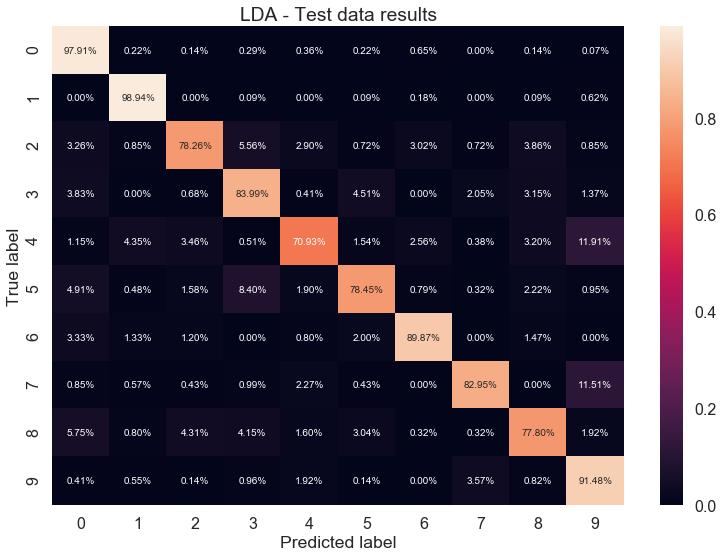

In [10]:
sbn.heatmap(test_cm, annot=True, fmt='.2%')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('LDA - Test data results')
plt.show()
plt.close()

In [11]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
sklearn_model = LDA(solver='lsqr').fit(X_train, y_train)

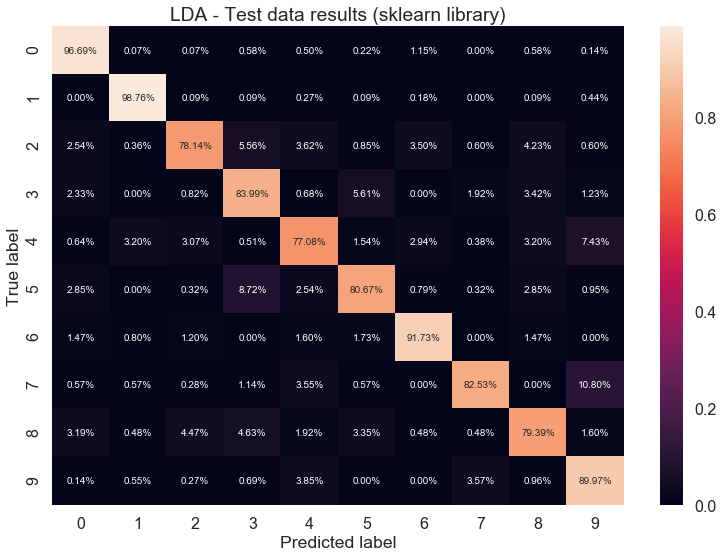

In [12]:
predictions = sklearn_model.predict(X_test)
cm_sklear = confusion_matrix(y_test, predictions, normalize='true')

sbn.heatmap(cm_sklear, annot=True, fmt='.2%')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('LDA - Test data results (sklearn library)')
plt.show()
plt.close()

#### Answers:

The confusion matrices plotted above summarize the results from the LDA. From these results, we can conclude that the digit $4$ is the most misclassified one (misclassification rate $29.07\%$), and it is misclassified as $9$ the most often ($11.91\%$ rate). The digit $7$ is also predicted as $9$ often ($11.51\%$ rate). The general classification error is $13.23\%$.

We can also compare the results with those from the `sklearn` library. These are very similar.

### b) [25 points] Regularized quadratic discriminate analysis

QDA does not work directly in this example because we do not have enough samples to provide invertible class-specific sample covariance matrix. An alternative idea to fix this issue is to consider a regularized QDA method, which uses 
$$\widehat \Sigma_k(\alpha) = \alpha \widehat \Sigma_k + (1-\alpha) \widehat \Sigma $$
for some $\alpha \in (0, 1)$. Here $\widehat \Sigma$ is the estimator from the LDA method. Implement this method and select the best tuning parameter (on a grid) based on the testing error. You should again report the model fitting results similar to the previous part. What is your best tuning parameter, and what does that imply in terms of the underlying data and the performance of the model?  

In [13]:
def quadratic_discriminant(X, y, alpha):
    '''
    Fits quadratic discriminant analysis parameters from training data X and training outcomes y.
    
    Arguments
    --------------
    X: np.ndarray of shape (n_samples, n_features). Training data.
    y: np.ndarray of shape (n_samples,). Training outcomes. Labels must be in range [0, n_classes).
    alpha: float in range (0, 1). Regularization parameter.
    
    Returns
    --------------
    dict with keys:
        'predictions': np.ndarray of shape (n_samples,). Predicted outcomes for training data.
        'error': float. Classification error for training data.
        'conf_matrix': np.ndarray of shape (n_classes, n_classes). Confusion matrix (normalized) for training data.
        'misclass_rates': np.ndarray of shape (n_classes,). Misclassification rate for each class.
        'model': callable. Function that returns predicted labels for new data.
        'params': tuple of (w, b). Fitted parameters for QDA.
            w: np.ndarray of shape (n_classes, n_features). 
            b: np.ndarray of shape (n_classes.)
    '''
    
    n_samples, n_features = X.shape
    classes, counts = np.unique(y, return_counts=True)
    n_classes = classes.shape[0]
    
    priors = compute_priors(counts)
    centroids = compute_centroids(X, y, classes, n_classes, n_features)
    covariances = compute_covariance_QDA(X, y, alpha, centroids, classes, n_samples, n_features, n_classes)
    params = compute_params_QDA(priors, covariances, centroids, classes, n_features, n_classes)
    model = qda_model(params, classes, n_classes)
    predictions = model(X)
    error = classification_error(y, predictions)
    conf_matrix = confusion_matrix(y, predictions, normalize='true')
    misclass_rates = 1 - conf_matrix.diagonal()
    
    output = {}
    output['predictions'] = predictions
    output['error'] = error
    output['conf_matrix'] = conf_matrix
    output['misclass_rates'] = misclass_rates
    output['model'] = model
    output['params'] = params
    
    return output
    
def compute_covariance_QDA(X, y, alpha, centroids, classes, n_samples, n_features, n_classes):
    '''
    Helper function to compute covariances matrices.
    '''
    LDA_cov = compute_covariance(X, y, centroids, classes, n_samples, n_features, n_classes)
    
    covariances = []
    for k in classes:
        mask = np.where(y == k)
        Xk = X[mask]
        cov = alpha*np.cov(Xk, rowvar=False, bias=1) + (1-alpha)*LDA_cov
        covariances.append(cov)
    
    return covariances

def compute_params_QDA(priors, covariances, centroids, classes, n_features, n_classes):
    '''
    Helper to compute QDA parameters.
    '''
    
    W = np.empty((n_classes, n_features, n_features))
    w = np.empty((n_classes, n_features))
    b = np.empty(n_classes)
    
    for k in classes:
        centroid = centroids[k]
        prior = priors[k]
        covariance = covariances[k]
        cov_inv = np.linalg.inv(covariance)
        
        b[k] = -0.5*np.matmul(centroid, np.matmul(cov_inv, centroid.T)) + np.log(prior)
        w[k] = np.matmul(cov_inv, centroid)
        W[k] = -0.5*cov_inv
    
    return W, w, b

def qda_model(params, classes, n_classes):
    '''
    Returns a callable LDA model.
    '''
    
    W, w, b = params
    
    def model(X):
        n_samples = X.shape[0]
        pred_matrix = np.empty((n_samples, n_classes))
        
        for k in classes:
            Wk = W[k]
            wk = w[k]
            bk = b[k]
            for n, x in enumerate(X):
                A = np.matmul(x, np.matmul(Wk, x.T))
                B = np.matmul(x, wk.T)
                pred_matrix[n, k] = A + B + bk
            
            
        pred = np.argmax(pred_matrix, axis=1)
        return pred
    
    return model

In [14]:
results_qda = []
errors = []
for alpha in np.arange(0.1, 1, 0.1):
    results_qda = quadratic_discriminant(X_train, y_train, alpha)
    model = results_qda['model']
    pred = model(X_test)
    error = classification_error(y_test, pred)
    errors.append(error)

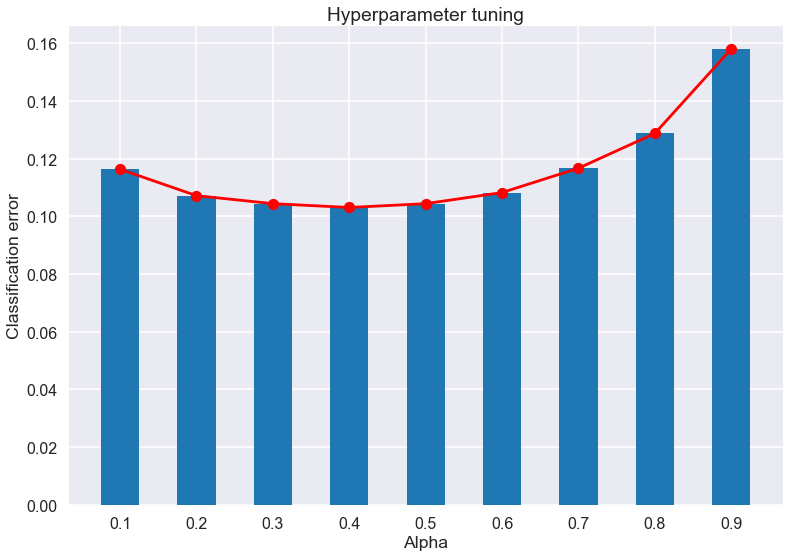

In [15]:
plt.bar(np.arange(0.1, 1, 0.1), errors, width=0.05)
plt.plot(np.arange(0.1, 1, 0.1), errors, c='r', marker='o')
plt.xticks(np.arange(0.1, 1, 0.1))
plt.title("Hyperparameter tuning")
plt.xlabel("Alpha")
plt.ylabel("Classification error")
plt.show()

In [16]:
print("Errors:", np.round(errors, 3))

Errors: [0.116 0.107 0.104 0.103 0.104 0.108 0.117 0.129 0.158]


I will use $\alpha = 0.4$ because it has the lowest classification error in the test set.

In [17]:
results_qda = quadratic_discriminant(X_train, y_train, 0.4)

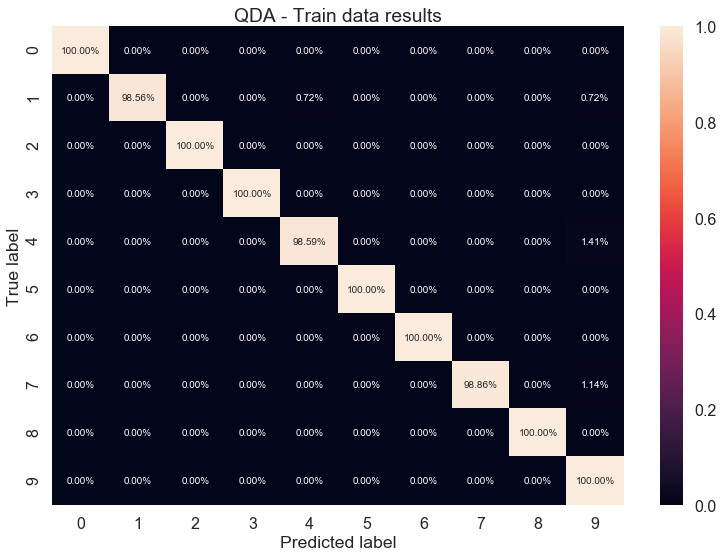

In [18]:
cm = results_qda['conf_matrix']
sbn.heatmap(cm, annot=True, fmt='.2%')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('QDA - Train data results')
plt.show()
plt.close()

In [19]:
test_pred = results_qda['model'](X_test)
test_error = classification_error(y_test, test_pred)
test_cm = confusion_matrix(y_test, test_pred, normalize='true')

In [20]:
print("Test misclassification rates:")
print(np.round(1 - test_cm.diagonal(), 4))

Test misclassification rates:
[0.0115 0.0142 0.0966 0.1518 0.2394 0.1838 0.0813 0.125  0.1901 0.0838]


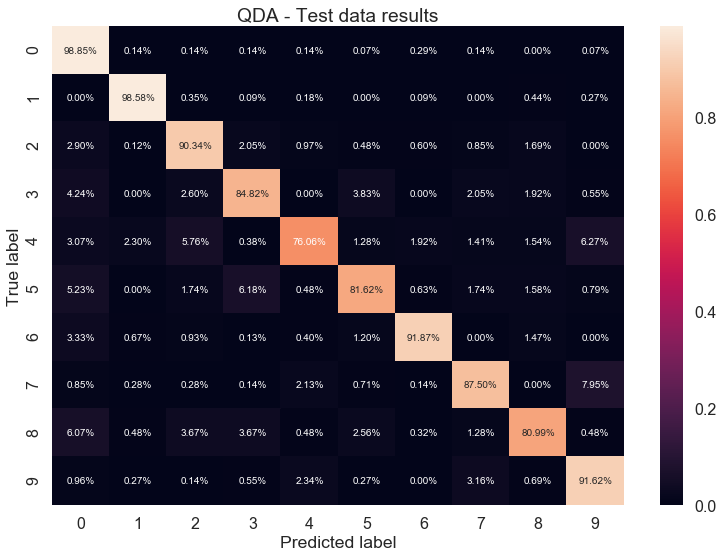

In [21]:
sbn.heatmap(test_cm, annot=True, fmt='.2%')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('QDA - Test data results')
plt.show()
plt.close()

#### Answer:

The digit that is misclassified the most by the model is $4$, like in LDA, because in many cases ($6.27\%$) it is classified as a $9$. This is also the case for the digit $7$. The general classification error was $10.3\%$.

Upon tuning the $\alpha$ parameter, I found that $0.4$ was optimal. This implies that the class-specific covariance matrices differ substantially. The regularization serves to shrink these matrices towards the pooled covariance, preventing estimation instabilities.

**Source:** 

Friedman, Jerome H. “Regularized Discriminant Analysis.” Journal of the American Statistical Association, vol. 84, no. 405, 1989, pp. 165–175. JSTOR, www.jstor.org/stable/2289860.

## Question 2 [50 Points] Logistic Regression

We consider a logistic regression problem using the South Africa heart data as a demonstration. The goal is to estimate the probability of `chd`, the indicator of coronary heart disease. The following code is used to prepare the data and fit the logistic regression. Please note that the factor variable `famhist` has been converted to a dummy. 

```{r}
    library(ElemStatLearn)
    data(SAheart)
    
    heart = SAheart
    heart$famhist = as.numeric(heart$famhist)-1
    n = nrow(heart)
    p = ncol(heart)
    
    heart.full = glm(chd~., data=heart, family=binomial)
    
    # fitted value 
    yhat = (heart.full$fitted.values>0.5)
    table(yhat, SAheart$chd)
    
    # data we use
    X <- as.matrix(cbind("intercept" = 1, heart[,-10]))
    Y <- as.matrix(heart$chd)
```

We can obtain the logistic regression fitting by write our own code. For example, in our [R-intro](https://teazrq.github.io/stat432/other/r-intro.html) file, section 10, there is an example of solving the $\beta$ parameters in a linear regression. We are going to adapt that strategy by:

  * Defining the log-likelihood function of a logistic regression
  * Further incorporating the gradient function to improve the computational efficiency

First, write a function `logisticLL(b, X, Y)` that calculates the log-likelihood function of $n$ observations given the design matrix `X`, a vector of binary outcomes `Y` and any given vector of parameter values `b`. Please note that the first element in `b` is the intercept since the first column if `X` should be 1, as provided in our code above. Then, perform the optimization of the logistic regression using the `optim` function. There are a few things you should be careful about: 

  * Are you maximizing or minimizing the objective function? Is that specified correctly in the `optim` function
  * Use `method = "BFGS"` for the optimization

In the second step, you should write a gradient function `logisticG(b, X, Y)` that calculates the gradient vector. Then call the `optim` again to incorporate this gradient. For both steps, compare your results to the output from the `glm()` function in terms of the estimated parameters and the training data accuracy.

In [22]:
# Load dataset
import pandas as pd
heart_data = pd.read_csv('SAheart.csv')
heart_data.famhist = np.asarray([1 if fh == 'Present' else 0 for fh in heart_data.famhist])

heart_data_array = np.asarray(heart_data)[:, 1:]
# Add intercept
heart_data_array = np.insert(heart_data_array, 0, 1, axis=1)

In [23]:
# I normalize the data to avoid numerical instabilities when computing the exponential
heart_data_norm = heart_data_array / heart_data_array.max(axis=0)

X, y = heart_data_norm[:, :-1], heart_data_norm[:, -1]

In [24]:
def logisticLL(b, x):
    '''
    Logistic log-likelihood for parameters b with training data X and binary outcomes y.
    '''
    X, y = x[:, :-1], x[:, -1]
    v = np.matmul(X, b)
    A = np.matmul(y, v)
    B = np.log(1 + np.exp(v)).sum()
    
    return A - B

def logisticG(b, x):
    '''
    Logistic log-likelihood gradient for parameters b with training data X and binary outcomes y.
    '''
    X, y = x[:, :-1], x[:, -1]
    A = np.zeros((X.shape[1]))
    B = np.zeros((X.shape[1]))
    
    for x, y in zip(X, y):
        A += np.dot(y, x)
        c = np.exp(np.dot(x, b))
        B += c*x/(1 + c)
        
    return A - B

def get_predictions(X, b):
    '''
    Apply threshold to get predictions.
    '''
    log_prob = np.matmul(X, b)
    
    return np.asarray([1 if lp >= 0.5 else 0 for lp in log_prob]).astype(int)

In [25]:
from scipy.optimize import minimize
initial_guess = np.ones(10)
# We use -logisticLL because we want to maximize the log-likelihood
f = lambda b, x: -logisticLL(b, x)

results_no_gradient = minimize(f, initial_guess, method='BFGS', args=(heart_data_norm))

In [26]:
print("Parameters with no gradient:\n", np.round(results_no_gradient.x, 3))

Parameters with no gradient:
 [-6.151  1.418  2.477  2.666  0.79   0.925  3.088 -2.93   0.018  2.894]


In [27]:
g = lambda b, x: -logisticG(b, x)

results_gradient = minimize(f, initial_guess, method='BFGS', args=(heart_data_norm), jac=g)

In [28]:
print("Parameters with gradient:\n", np.round(results_gradient.x, 3))

Parameters with gradient:
 [-6.151  1.418  2.477  2.666  0.79   0.925  3.088 -2.93   0.018  2.894]


In [29]:
from sklearn.linear_model import LogisticRegression
sklearn_model = LogisticRegression(penalty='none', fit_intercept=False, random_state=1).fit(X, y)
print("Parameters from sklearn:\n", np.round(sklearn_model.coef_, 3))

Parameters from sklearn:
 [[-6.152  1.418  2.476  2.667  0.79   0.925  3.089 -2.93   0.018  2.895]]


In [30]:
predictions_no_gradient = get_predictions(X, results_no_gradient.x)
error_no_gradient = classification_error(y, predictions_no_gradient)

predictions_gradient = get_predictions(X, results_gradient.x)
error_gradient = classification_error(y, predictions_gradient)

predictions_sklearn = sklearn_model.predict(X)
error_sklearn = classification_error(y, predictions_sklearn)

In [31]:
print("Error no gradient:", error_no_gradient)
print("Error gradient:", error_gradient)
print("Error sklearn:", error_sklearn)

Error no gradient: 0.2554112554112554
Error gradient: 0.2554112554112554
Error sklearn: 0.2662337662337662


#### Answers:

We can observe that the estimated parameters obtained using the `minimize` function are virtually identical to those obtained using the `LogisticRegression` model from `sklearn`. Thus, it is no surprise that the error rates also match within one percentage point. It should also be noted that adding the explicit function for the gradient did not improve the performance of the optimization function. The `minimize` function uses a 2-point approximation for the gradient when no `jac` (Jacobian) parameter is given. It seems that this approximation is good enough for this problem.